In [1]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt

N_DIMS = 1 # Number of dimensions
NUM_EPOCHS = 500 # Number of epochs
SEED = 44
GAMMA = 1 / 10
tkwargs = {"device": "cpu", "dtype": torch.float64}

In [2]:
# Setting seed for reproducibility
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
def forrester(x, noise=False):
    f = np.sin(3*x) + x**2 - 0.7*x + 1
    if noise:
        f += np.random.normal(0, .2, f.shape)
    return f

In [4]:
from sklearn.ensemble import RandomForestClassifier
from botorch.utils.sampling import draw_sobol_samples


def train_auxiliary_classifier(X):
    x_m = draw_sobol_samples(bounds=torch.tensor([[-1.], [2.]], **tkwargs), n=len(X), q=1).squeeze(1).numpy()
    x = np.concatenate([X, x_m], axis=0)
    z_p = np.zeros(X.shape[0])
    z_m = np.ones(x_m.shape[0])
    z = np.concatenate([z_p, z_m], axis=0)
    auxi_clf = RandomForestClassifier(n_estimators=100, class_weight='balanced')
    auxi_clf.fit(x, z)
    return auxi_clf

def prepare_data_mdre(X, y, gamma):

    auxi_clf = train_auxiliary_classifier(X)

    tau = np.quantile(y, q=gamma)
    z = np.less(y, tau)

    x_p, y_p = X[z.squeeze()], y[z.squeeze()]
    w_p = (tau - y)[z]
    w_p = w_p / np.mean(w_p)

    x_q, y_q = X, y
    x_m = draw_sobol_samples(bounds=torch.tensor([[-1.], [2.]], **tkwargs), n=len(x_q), q=1).squeeze(1).numpy()
    x = np.concatenate([x_p, x_q, x_m], axis=0)

    z_p = np.zeros(x_p.shape[0])
    z_q = np.ones(x_q.shape[0])
    z_m = np.ones(x_m.shape[0]) * 2
    z = np.concatenate([z_p, z_q, z_m], axis=0)

    s_p = x_p.shape[0]
    s_q = x_q.shape[0]
    s_m = x_m.shape[0]
    w_p = w_p * (s_p + s_q + s_m) / s_p
    w_q = z_q * (s_p + s_q + s_m) / s_q

    probs = auxi_clf.predict_proba(x_m)
    w_m = np.clip(probs[:, 1] - 0.5, a_min=0, a_max=None) * 2 * (s_q + s_p + s_m) / s_m
    # w_m = z_q * (s_q + s_p + s_m) / s_m
    
    w = np.concatenate([w_p, w_q, w_m], axis=0)
    w = w / w.mean()

    return x, z, w, tau

In [5]:
dense_x = np.linspace(-1, 2, 1024).reshape(-1, 1)
dense_y = forrester(dense_x, noise=False)

In [6]:
def plot_step_through_mdre(X_obs, y_obs, z_obs, new_x, new_y, tau, dr, acf, ax_func, ax_acf):
    ax_func.plot(dense_x, dense_y, color='k', label="objective function")
    ax_func.axhline(tau, linestyle='--', color='tab:gray', alpha=.7, label=r'$\tau$')

    x_p = X_obs[z_obs==0]
    y_p = y_obs[z_obs==0]
    x_q = X_obs[z_obs==1]
    y_q = y_obs[z_obs==1]
    x_m = X_obs[z_obs==2]
    
    ax_func.scatter(x_q, y_q, marker='x', color='tab:blue', label="bad")
    ax_func.scatter(x_p, y_p, marker='x', color='tab:red', label="good")
    ax_func.scatter(new_x, new_y, marker='*', label="new x", color='tab:orange', s=50)
    ax_func.plot(dense_x, acf[:, 1], color='tab:blue',)
    ax_func.plot(dense_x, acf[:, 0], color='tab:red',)
    ax_func.plot(dense_x, acf[:, 2], color='tab:green',)
    ax_func.set_xlim(-1., 2.)
    ax_func.set_ylim(0, None)
    ax_func.set_title('MDRE')

    ax_func.plot(
        x_m,
        np.zeros(len(x_m)),
        '|',
        markersize=12,
        color="tab:green"
    )
    ax_acf.plot(
        dense_x.flatten(),
        dr,
        label=r"$\ell(x)$",
    )
#     ax_acf.fill_between(
#         dense_x.flatten(),
#         dr,
#         0,
#         facecolor="#2ca02c3f",
#         edgecolor="#2ca02c",
#         label=r"$\ell(x)$",
#     )
    ax_acf.set_xlim(-1, 2)
#     ax_acf.set_ylim(0, None)
    ax_acf.set_xlabel('x')
    ax_acf.set_ylabel('log density ratio')

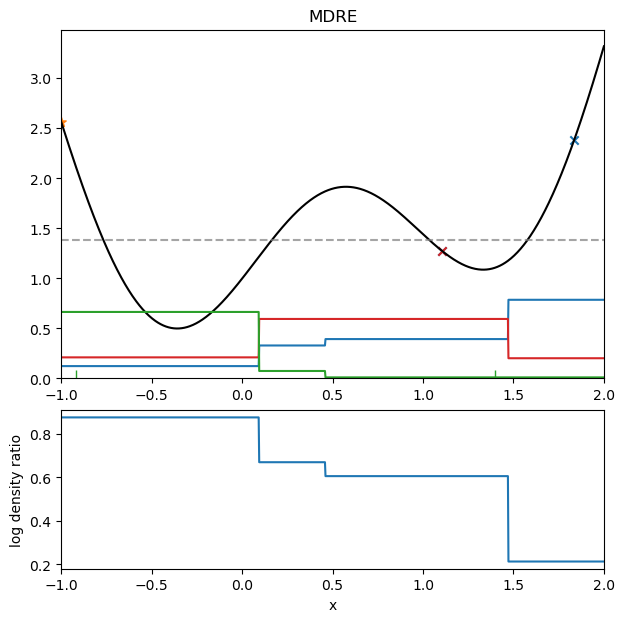

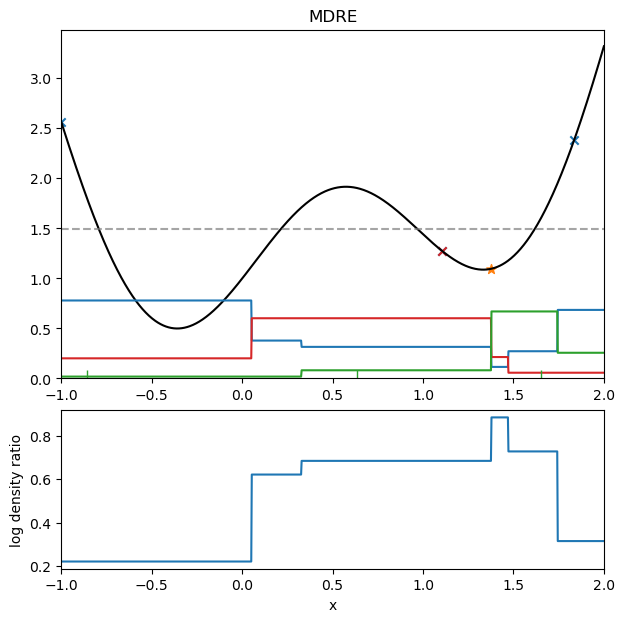

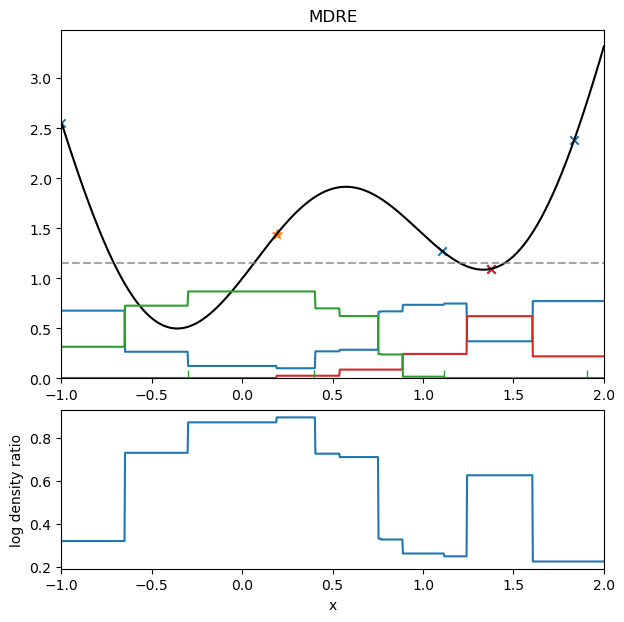

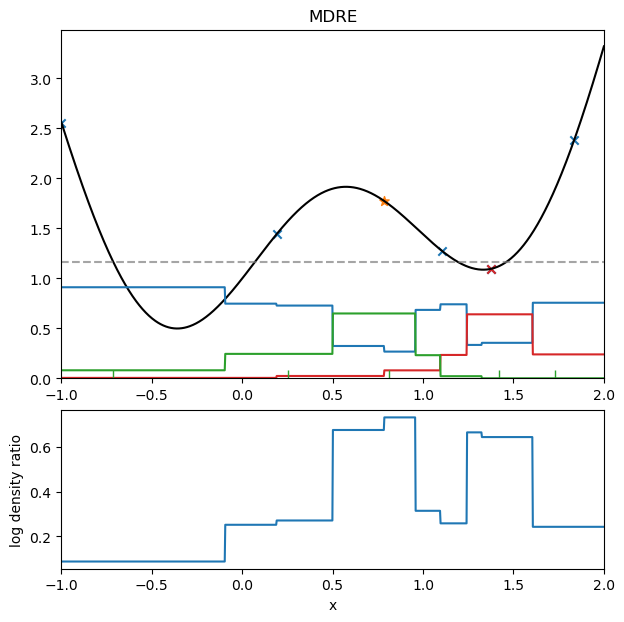

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:910: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


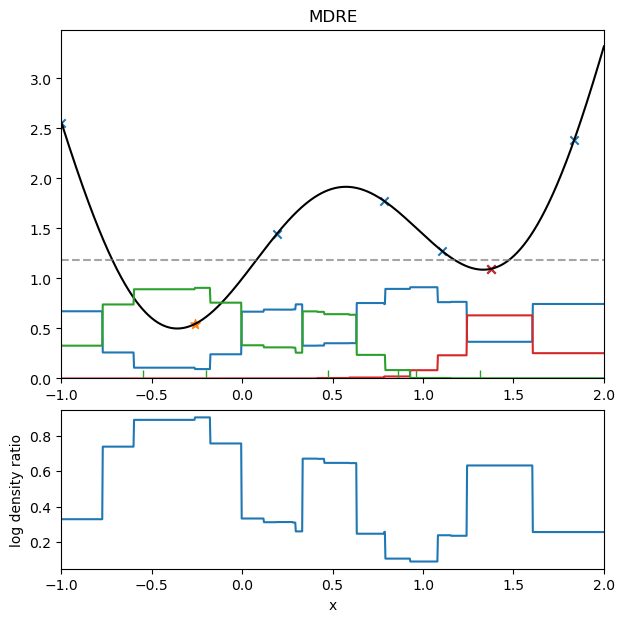

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:910: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


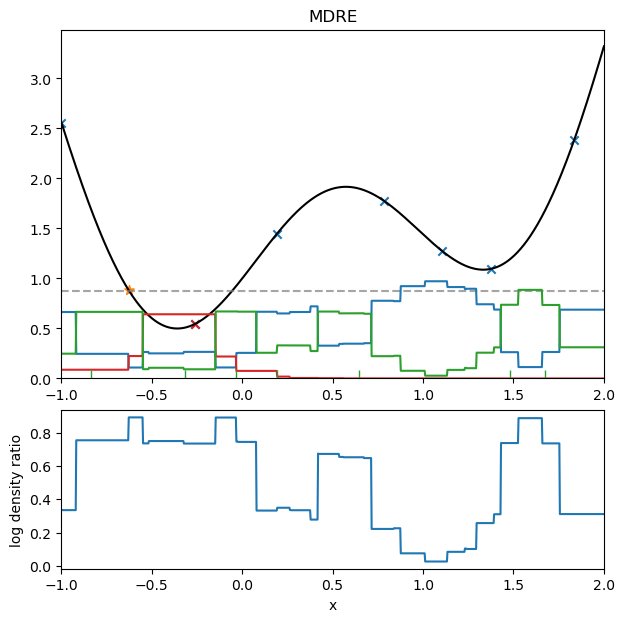

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:910: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


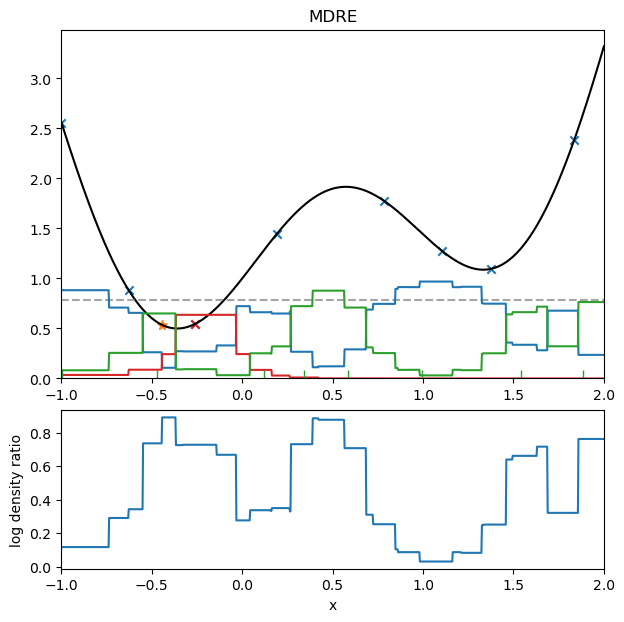

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:910: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


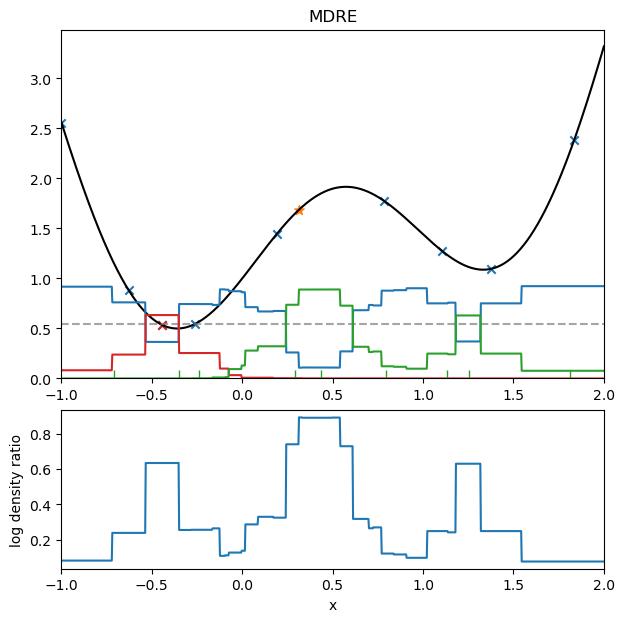

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:910: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


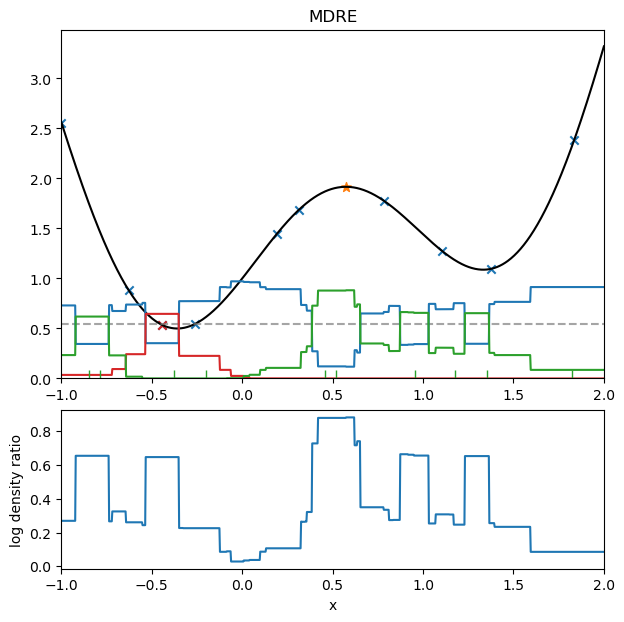

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:910: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


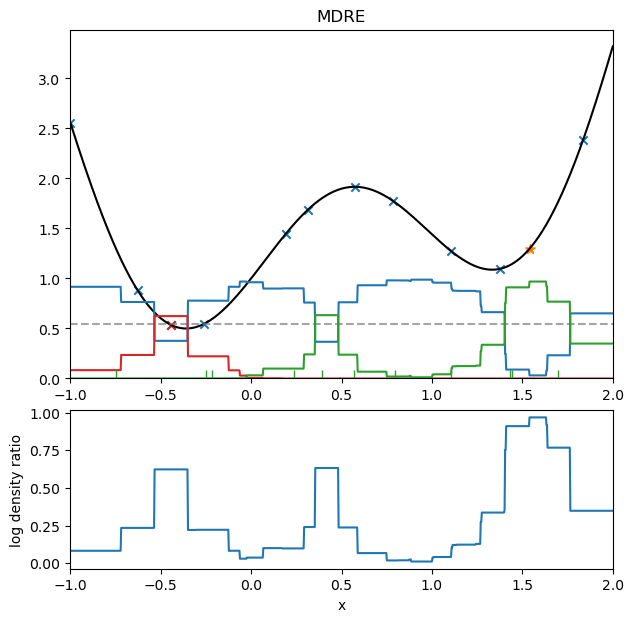

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:910: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


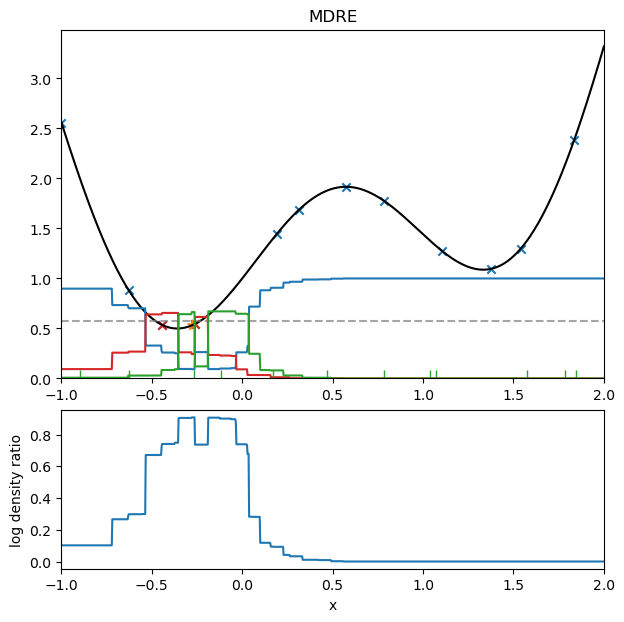

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:910: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


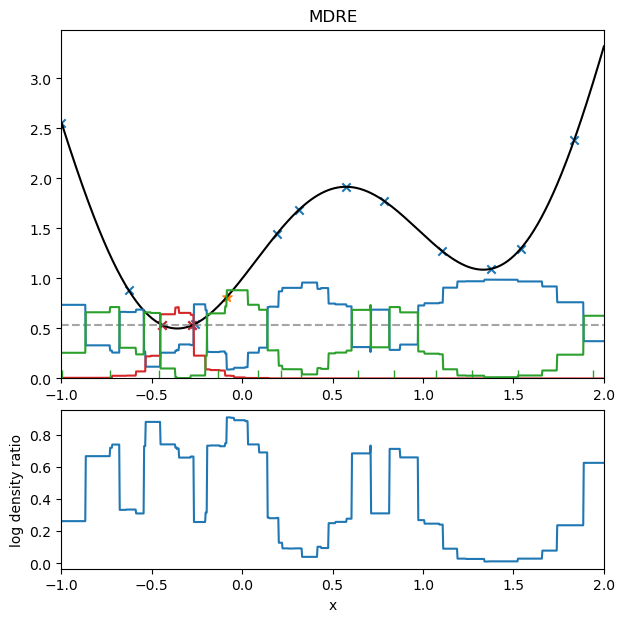

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:910: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


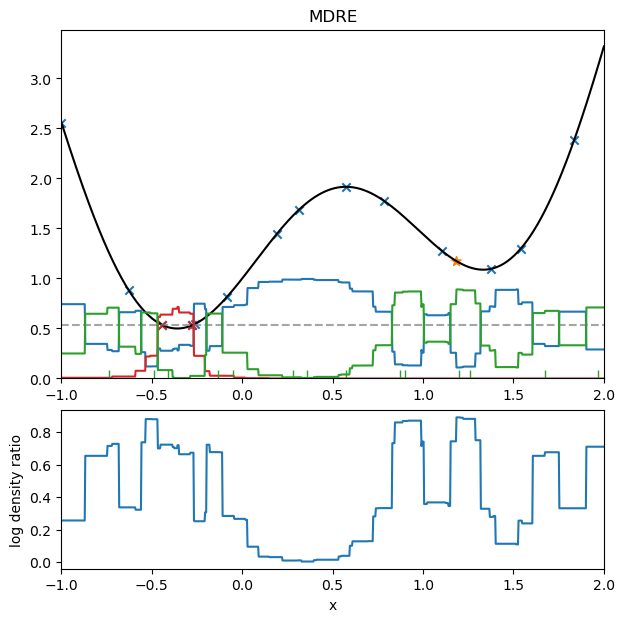

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:910: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


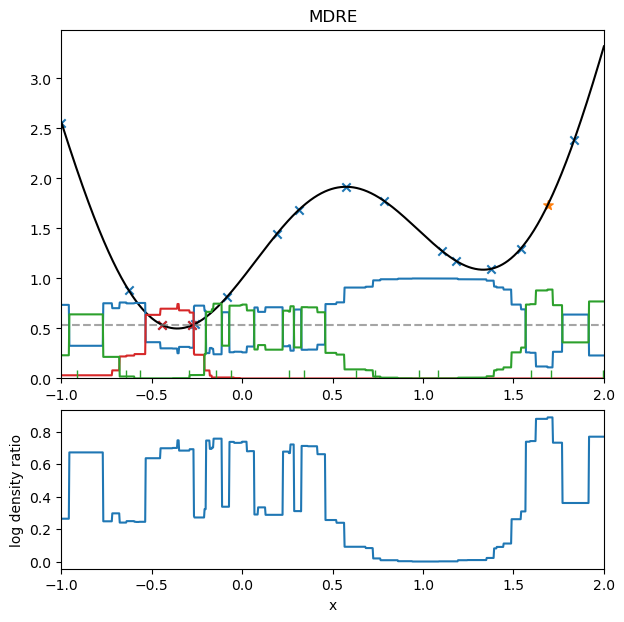

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:910: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


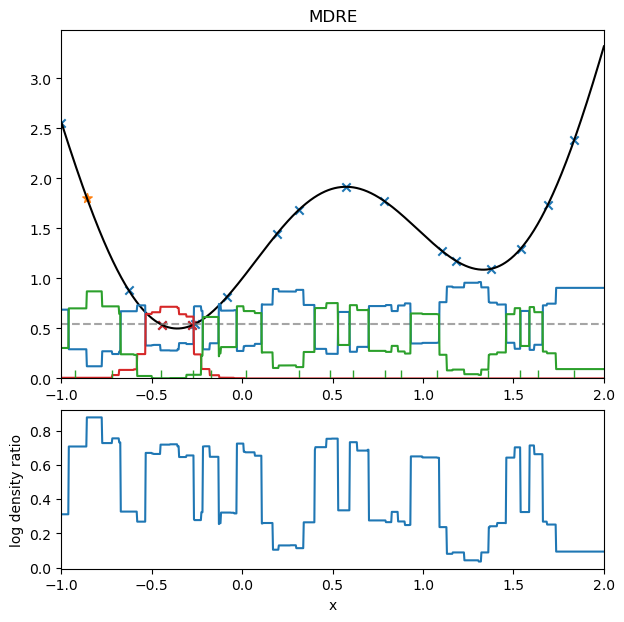

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:910: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


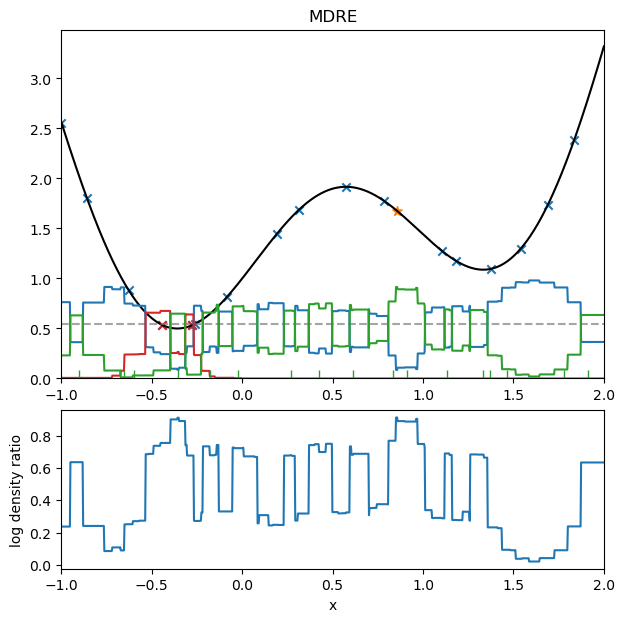

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:910: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


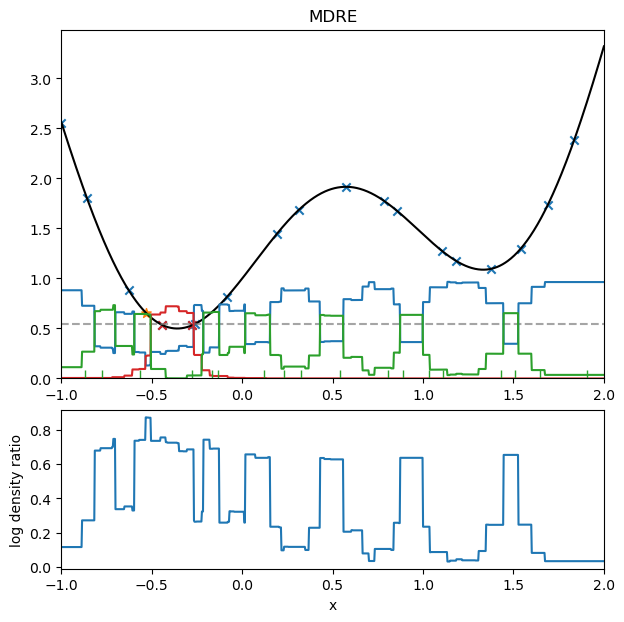

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:910: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


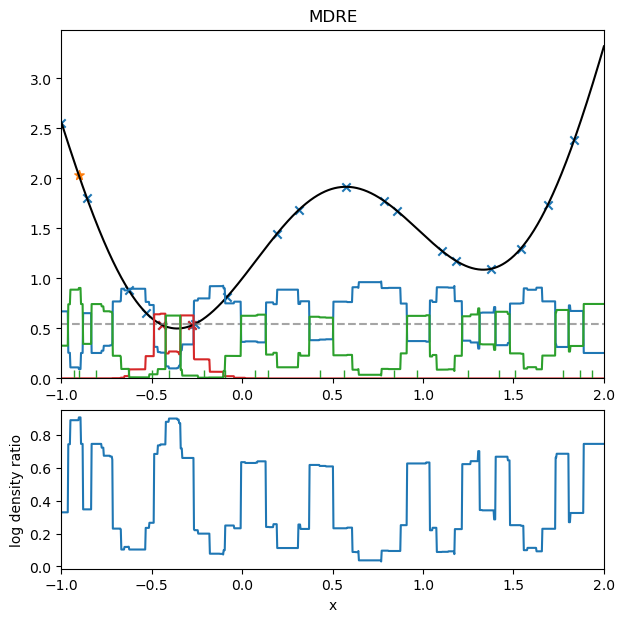

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:910: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


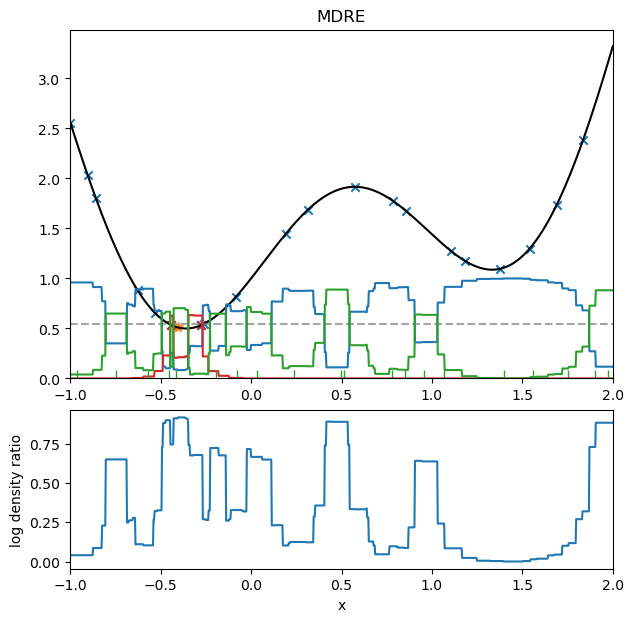

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:910: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


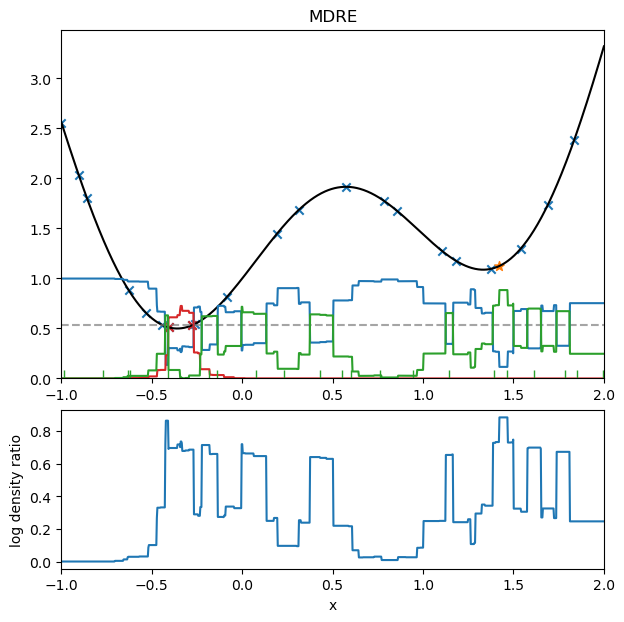

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:910: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


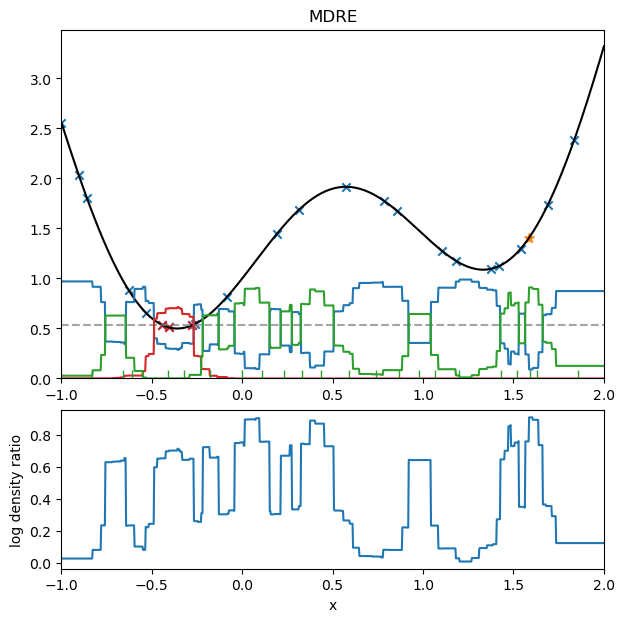

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:910: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


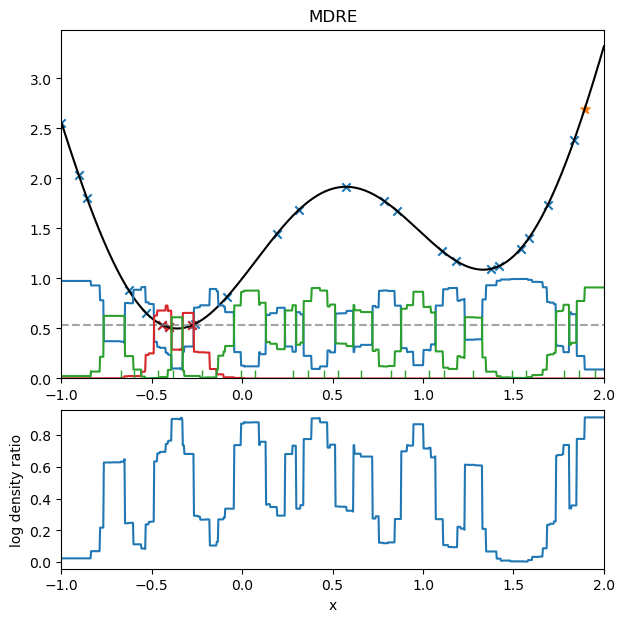

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:910: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


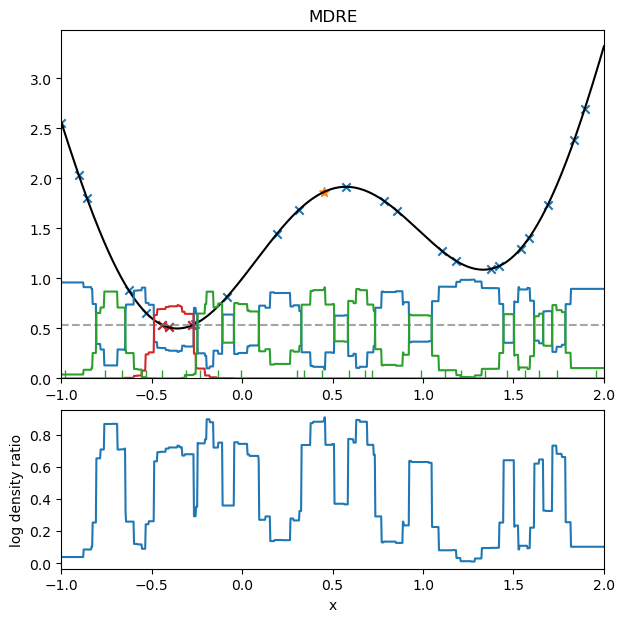

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:910: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


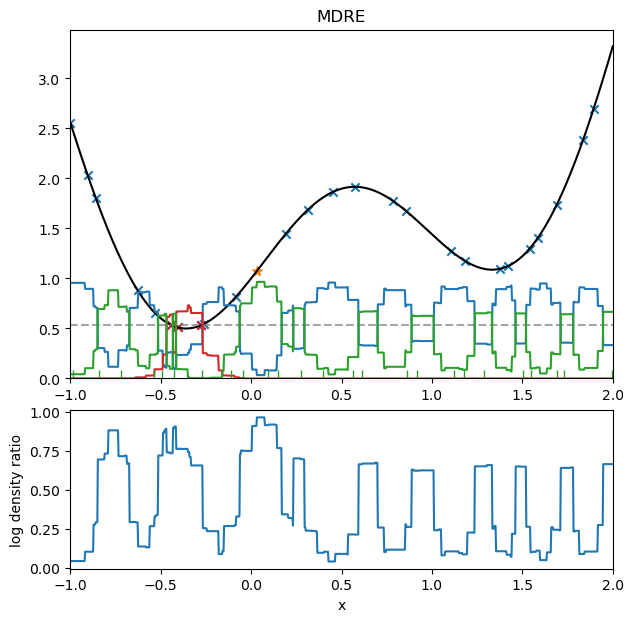

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:910: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


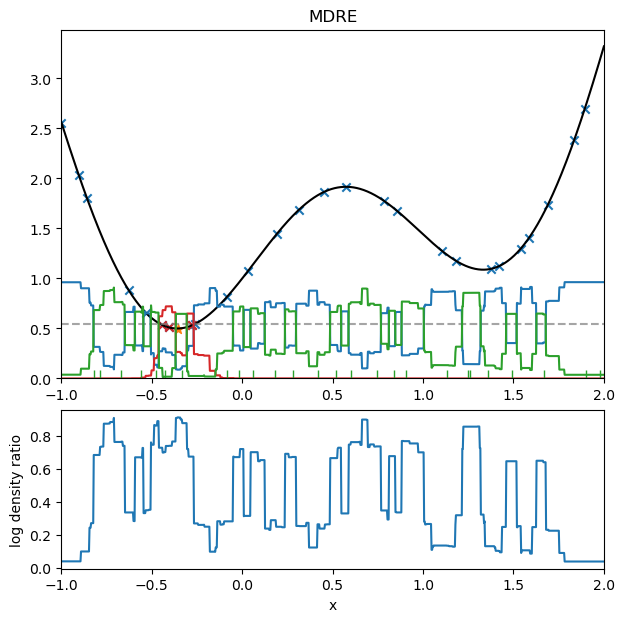

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:910: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


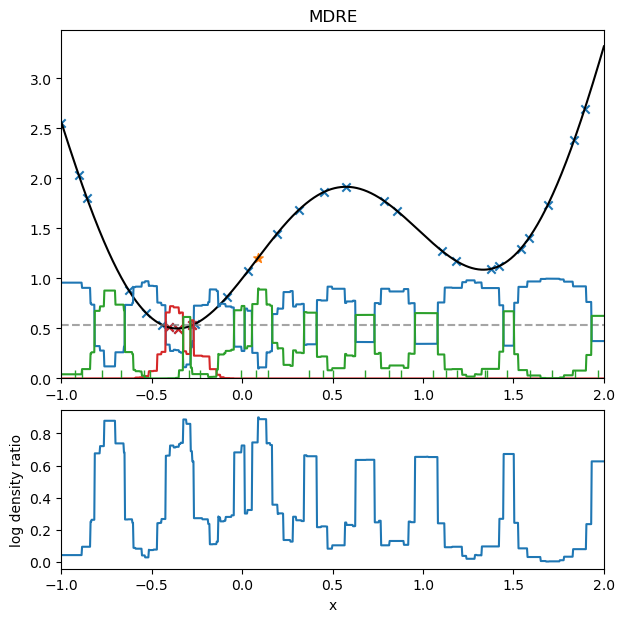

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:910: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


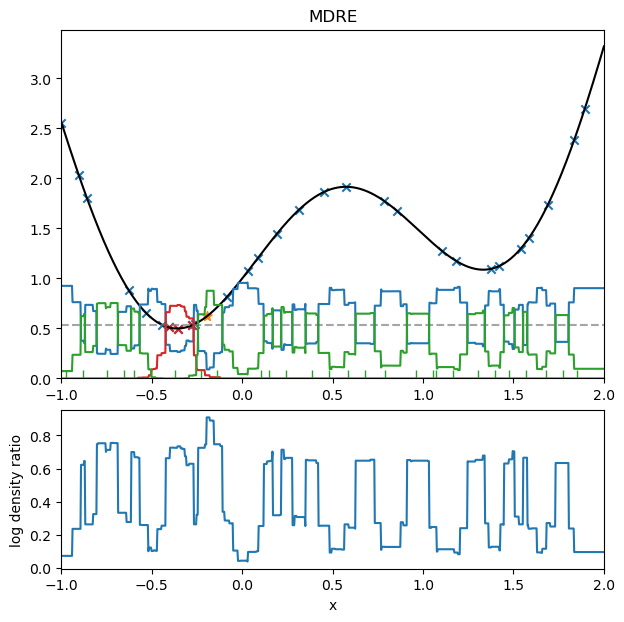

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:910: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


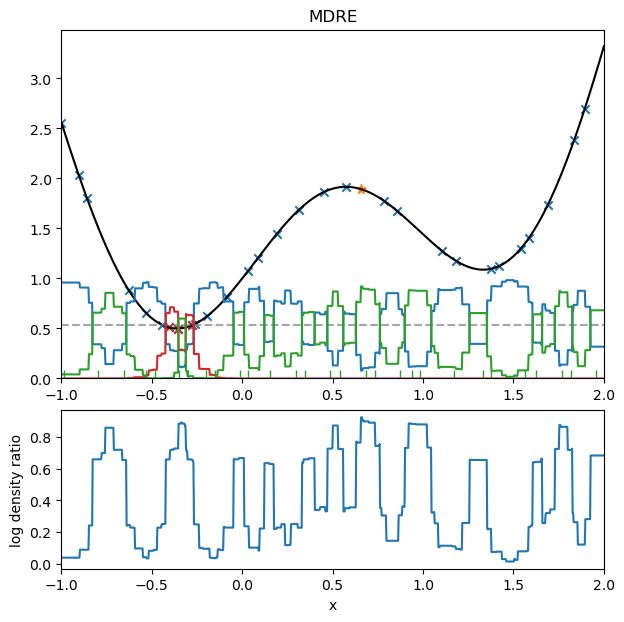

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:910: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


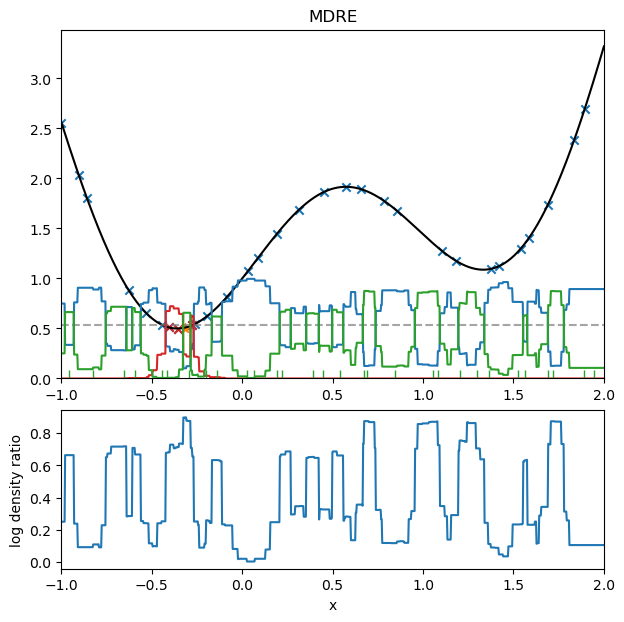

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:910: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


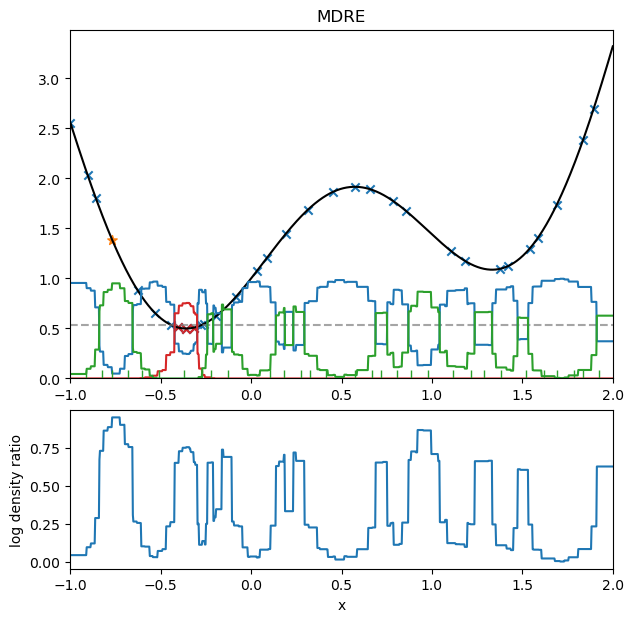

In [7]:
X_obs = np.random.uniform(-1, 2, (2, 1))
y_obs = forrester(X_obs, noise=False)

X_obs_mdre, y_obs_mdre = X_obs, y_obs

num_evaluations = 1

for n in range(num_evaluations):
    
    fig = plt.figure(figsize=(7, 7))
    ax_func_mdre = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax_acf_mdre = plt.subplot2grid((3, 1), (2, 0), rowspan=1)

    X_train_mdre, z_train_mdre, weight, tau = prepare_data_mdre(X_obs_mdre, y_obs_mdre, gamma=GAMMA)
    mdre = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
#     mdre = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
    y_train_mdre = forrester(X_train_mdre)
    mdre.fit(X_train_mdre, z_train_mdre, sample_weight=weight)
    acf_mdre = mdre.predict_proba(dense_x)
    mdre_preds = np.clip(mdre.predict_log_proba(dense_x), a_min=-1000, a_max=None)
    dr_mdre = 1 - acf_mdre[:, 1]
    # dr_mdre = mdre_preds[:, 0] + mdre_preds[:, 2] - mdre_preds[:, 1]
    new_x = dense_x[np.argmax(dr_mdre)]
    new_y = forrester(new_x, noise=False)
    plot_step_through_mdre(X_train_mdre, y_train_mdre, z_train_mdre, new_x, new_y, tau, dr_mdre, acf_mdre, ax_func_mdre, ax_acf_mdre)
    X_obs_mdre = np.concatenate([X_obs_mdre, new_x.reshape(-1, 1)])
    y_obs_mdre = np.concatenate([y_obs_mdre, new_y.reshape(-1, 1)])

    plt.show()